In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml # allows access to open source datasets from OpenML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA # this is what will be used for denoising in this example

X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True)
X = MinMaxScaler().fit_transform(X)

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, train_size=1_000, test_size=100)
rng = np.random.RandomState(0) # setting up random state for stability
noise = rng.normal(scale=0.25, size=X_test.shape)
X_test_noisy = X_test+noise # setting up noisy test data
noise = rng.normal(scale=0.25, size=X_train.shape)
X_train_noisy = X_train+noise # setting up noisy training data

In [3]:
# helper function for plotting test images
def plot_digits(X, title):
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8,8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16,16)), cmap='Greys')
        ax.axis('off')
        fig.suptitle(title, fontsize=24)

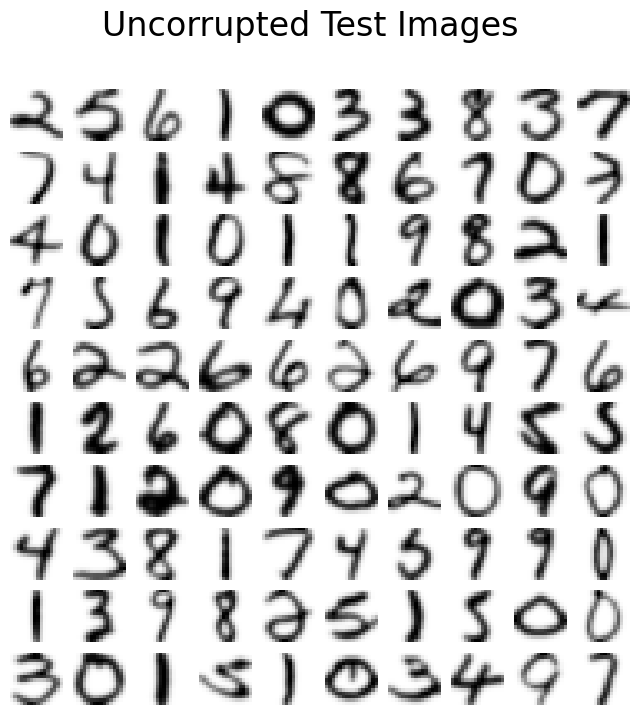

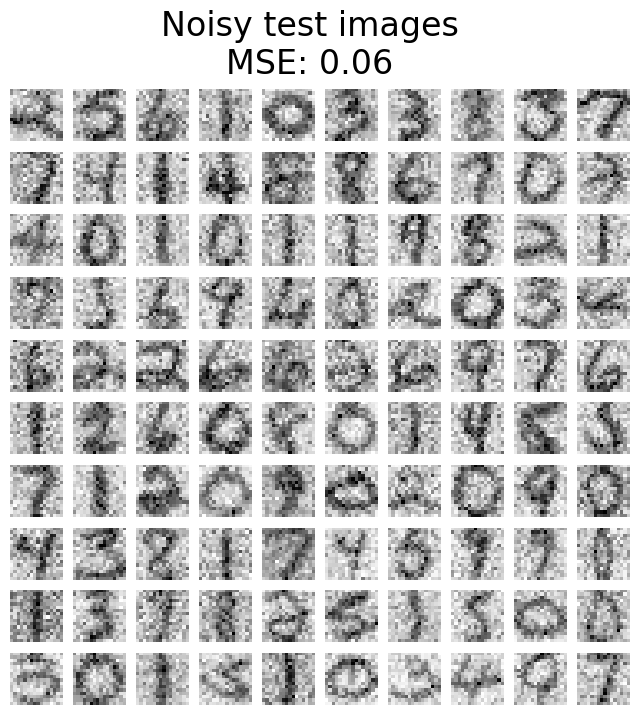

In [4]:
# plotting both original non-noisy digits and new noisy digits
plot_digits(X_test, 'Uncorrupted Test Images')
plot_digits(X_test_noisy, f'Noisy test images\nMSE: {np.mean((X_test - X_test_noisy) ** 2):.2f}')

In [5]:
# setting up PCA components
pca = PCA(n_components=32, random_state=42)
kernel_pca = KernelPCA(n_components=400, kernel='rbf', gamma=1e-3, fit_inverse_transform=True, alpha=5e-3, random_state=42,)
# training models with noisy data
pca.fit(X_train_noisy)
_= kernel_pca.fit(X_train_noisy)

In [6]:
# reconstructing and denoising using PCA models
X_reconstructed_kernel_pca = kernel_pca.inverse_transform(kernel_pca.transform(X_test_noisy))
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))

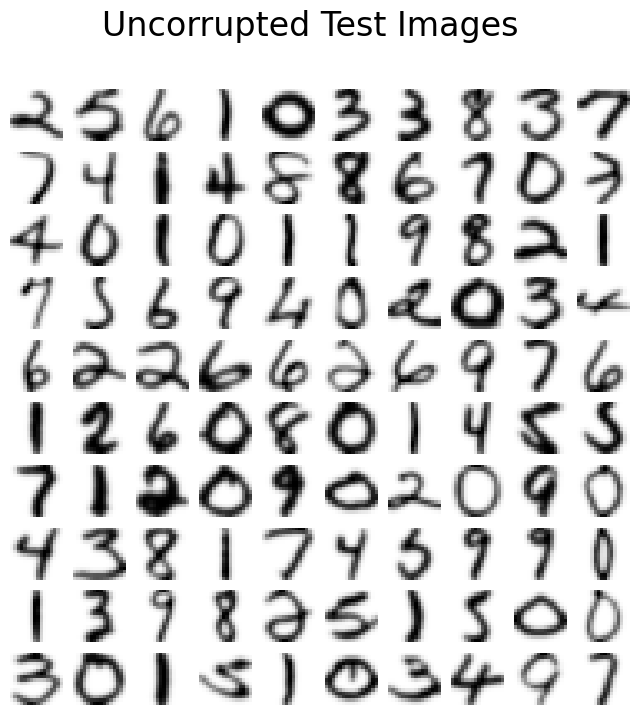

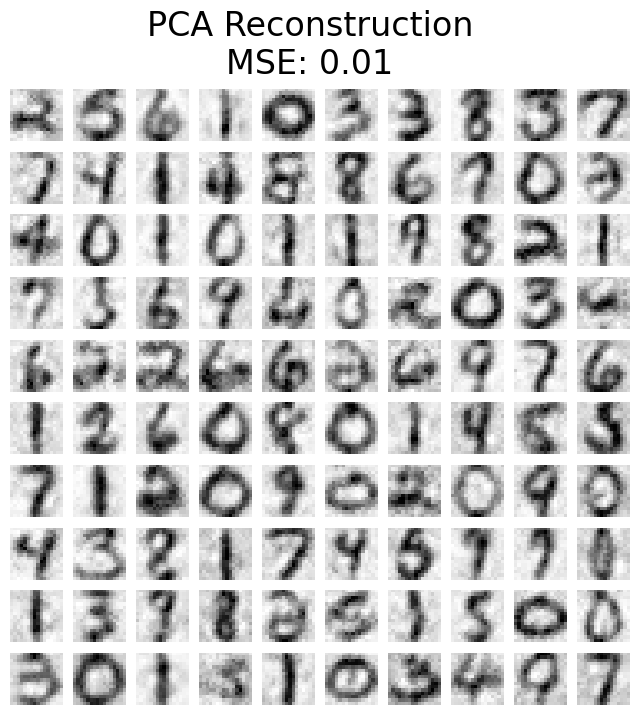

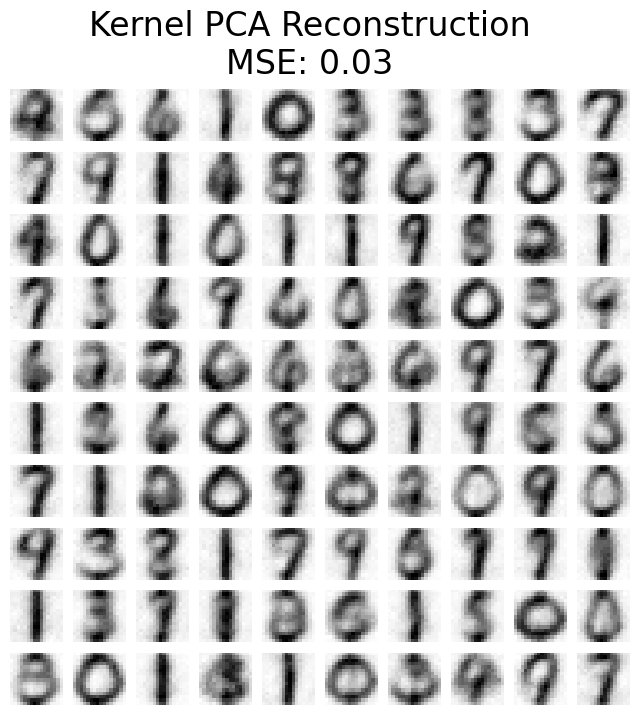

In [7]:
plot_digits(X_test, 'Uncorrupted Test Images')
plot_digits(X_reconstructed_pca, f'PCA Reconstruction\nMSE: {np.mean((X_test - X_reconstructed_pca) ** 2):.2f}',)
plot_digits(X_reconstructed_kernel_pca, ('Kernel PCA Reconstruction\n' f'MSE: {np.mean((X_test - X_reconstructed_kernel_pca) ** 2):.2f}'),)

In [8]:
# From the example above, it can be seen that regular PCA has a lower Mean Squared Error compared to Kernel PCA, however Kernel PCA is seen
# to remove more noise from the image. While PCA is generally faster and less complex, Kernel PCA is able to handle noise for data with more
# non-linear and complex data, making it so that Kernel PCA "looks" better. The main drawback of Kernel PCA is the fact that it uses up more
# processing and that it has to be tuned with parameters such as n_components, gamma, and alpha.